A Czech bank wants to improve its services by identifying who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank losses). The challenge is to use advanced data science tools and techniques to mine and analyze this bank's data in order to understand the most suitable customers to be offered a credit card product.

## Import & load

In [1]:
# Basic Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling 


# allows us to plot inline - overrides the Jupyter security feature for plotting (which would cause us to run cell twice)
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In C:\Users\amath\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\amath\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\amath\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\amath\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\amath\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# Machine Learning Modules from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.cluster import KMeans
from scipy import stats

import pyodbc # for connecting to SQL from Python

In [3]:
# establish an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-QTJ8HHV;'
                      'Database=Berka;'
                      'Trusted_Connection=yes;')

### Transaction (for exploration only)

In [4]:
# import transaction table from SQL (Berka Database)

pythonSQLobject=pd.read_sql_query("""
select *,
CASE
	WHEN k_symbol = 'SIPO' THEN 'household payment'
	WHEN k_symbol = 'POJISTNE' THEN 'insurance payment'
	WHEN k_symbol = 'SLUZBY' THEN 'statement payment'
	WHEN k_symbol = 'UROK' THEN 'interest credited'
	WHEN k_symbol = 'SANKC. UROK' THEN 'interest debited'
	WHEN k_symbol = 'DUCHOD' THEN 'pension credited'
	WHEN k_symbol = 'UVER' THEN 'loan payment'
END AS trans_type
from [dbo].[trans]
""", conn)

In [5]:
transaction_table = pythonSQLobject

In [6]:
transaction_table.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,trans_type
0,1,1,950324,PRIJEM,VKLAD,1000.0,1000.0,None,None,None,None
1,5,1,950413,PRIJEM,PREVOD Z UCTU,3679.0,4679.0,None,AB,41403269,None
2,6,1,950513,PRIJEM,PREVOD Z UCTU,3679.0,20977.2,None,AB,41403269,None
3,7,1,950613,PRIJEM,PREVOD Z UCTU,3679.0,26835.2,None,AB,41403269,None
4,8,1,950713,PRIJEM,PREVOD Z UCTU,3679.0,30414.8,None,AB,41403269,None


In [7]:
transaction_table.shape

(1056320, 11)

In [8]:
transaction_table.isna().sum()

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
trans_type    535314
dtype: int64

Half (535K) of trans_type values are missing. Similarly there's a lot missing data in 4 other columns (k_symbol, bank, account, trans_type).
We decided to ignore these columns as we are more interested in the account balance after each transaction rather than the nature of them

In [9]:
# check for duplicate rows

boolean = transaction_table.duplicated().any()

In [10]:
boolean

False

No duplicate rows found

### Account

In [11]:
pythonSQLobject=pd.read_sql_query("""
select c.client_id, min(a.date) date
from [dbo].[account] as a
left join [dbo].[disp] as d
on a.account_id = d.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
group by c.client_id
""", conn)

In [12]:
account_table = pythonSQLobject

In [13]:
account_table.date = pd.to_datetime(account_table.date, format='%y%m%d')
account_table.head()

,client_id,date
0,1,1995-03-24
1,10,1995-09-21
2,100,1995-12-25
3,1000,1993-02-08
4,1001,1996-09-18


### Balance

In [14]:
# pull average balance per transaction per customer via SQL query

pythonSQLobject=pd.read_sql_query("""
select c.client_id, sum(t.balance) balance, MAX(t.date) max_date
from [dbo].[trans] as t
left join [dbo].[account] as a
on t.account_id = a.account_id
left join [dbo].[disp] as d
on d.account_id = a.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
GROUP BY c.client_id
ORDER BY AVG(t.balance)/count(t.trans_id) desc
""", conn)

In [15]:
balance_table= pythonSQLobject # assign read object to variable

In [16]:
balance_table.max_date = pd.to_datetime(balance_table.max_date, format='%y%m%d')

In [17]:
balance_table.head()

,client_id,balance,max_date
0,872,241300.0,1998-11-20
1,3495,294400.0,1998-12-11
2,3496,294400.0,1998-12-11
3,1763,497500.0,1998-11-17
4,908,242000.0,1998-11-14


### Income

In [18]:
pythonSQLobject=pd.read_sql_query("""
select c.client_id, sum(amount) income
from [dbo].[trans] as t
left join [dbo].[account] as a
on t.account_id = a.account_id
left join [dbo].[disp] as d
on d.account_id = a.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
GROUP BY c.client_id, t.type
having t.type = 'PRIJEM'
""", conn)


In [19]:
income_table = pythonSQLobject

### Spending

In [20]:
pythonSQLobject=pd.read_sql_query("""
select c.client_id, avg(amount) spending
from [dbo].[trans] as t
left join [dbo].[account] as a
on t.account_id = a.account_id
left join [dbo].[disp] as d
on d.account_id = a.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
GROUP BY c.client_id, t.type
having t.type = 'VYDAJ'
""", conn)

In [21]:
spending_table = pythonSQLobject

### Transaction: Account + Income + Spending + Balance

In [22]:
trans_table = balance_table.merge(income_table)

In [23]:
trans_table = trans_table.merge(spending_table)
trans_table.head()

,client_id,balance,max_date,income,spending
0,872,241300.0,1998-11-20,34000.0,700.000000
1,3495,294400.0,1998-12-11,39300.0,1400.000000
2,3496,294400.0,1998-12-11,39300.0,1400.000000
3,1763,497500.0,1998-11-17,40100.0,1633.333333
4,908,242000.0,1998-11-14,34800.0,2000.000000


In [24]:
trans_table = trans_table.merge(account_table)
trans_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   client_id  5369 non-null   object        
 1   balance    5369 non-null   float64       
 2   max_date   5369 non-null   datetime64[ns]
 3   income     5369 non-null   float64       
 4   spending   5369 non-null   float64       
 5   date       5369 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 293.6+ KB


In [25]:
# calculate no. of months
trans_table['total_days'] = trans_table['max_date']  - trans_table['date'] # total days in deltatime
trans_table['total_days'] = (trans_table['total_days']/ np.timedelta64(1, 'D')).astype(int) # total days converted to int
trans_table['total_months'] = trans_table['total_days']/30.0 # convert days to months
    
trans_table.head()

,client_id,balance,max_date,income,spending,date,total_days,total_months
0,872,241300.0,1998-11-20,34000.0,700.000000,1997-12-25,330,11.0
1,3495,294400.0,1998-12-11,39300.0,1400.000000,1997-12-16,360,12.0
2,3496,294400.0,1998-12-11,39300.0,1400.000000,1997-12-16,360,12.0
3,1763,497500.0,1998-11-17,40100.0,1633.333333,1997-07-25,480,16.0
4,908,242000.0,1998-11-14,34800.0,2000.000000,1997-12-19,330,11.0


In [26]:
# calculate income & spending by month

trans_table['monthly_income'] = trans_table['income']/trans_table['total_months']
trans_table['monthly_spending'] = trans_table['spending']/trans_table['total_months']
trans_table['daily_balance'] = trans_table['balance']/trans_table['total_days']

trans_table.head()

,client_id,balance,max_date,income,spending,date,total_days,total_months,monthly_income,monthly_spending,daily_balance
0,872,241300.0,1998-11-20,34000.0,700.000000,1997-12-25,330,11.0,3090.909091,63.636364,731.212121
1,3495,294400.0,1998-12-11,39300.0,1400.000000,1997-12-16,360,12.0,3275.000000,116.666667,817.777778
2,3496,294400.0,1998-12-11,39300.0,1400.000000,1997-12-16,360,12.0,3275.000000,116.666667,817.777778
3,1763,497500.0,1998-11-17,40100.0,1633.333333,1997-07-25,480,16.0,2506.250000,102.083333,1036.458333
4,908,242000.0,1998-11-14,34800.0,2000.000000,1997-12-19,330,11.0,3163.636364,181.818182,733.333333


In [27]:
trans_table['daily_balance'].describe()

count     5369.000000
mean      7029.858862
std       3906.014140
min        211.176471
25%       3868.316461
50%       6388.536013
75%       9348.393120
max      26297.662332
Name: daily_balance, dtype: float64

In [28]:
trans_table = trans_table.drop(['date', 'spending', 'income','max_date','total_days', 'total_months', 'balance'], axis=1)
trans_table.head()

,client_id,monthly_income,monthly_spending,daily_balance
0,872,3090.909091,63.636364,731.212121
1,3495,3275.000000,116.666667,817.777778
2,3496,3275.000000,116.666667,817.777778
3,1763,2506.250000,102.083333,1036.458333
4,908,3163.636364,181.818182,733.333333


### Loan

In [29]:
# pull loan data from SQL (Czech bank, Berka Database)

pythonSQLobject=pd.read_sql_query("""
select l.loan_id, c.client_id, l.status, l.duration, l.date
from [dbo].[loan] as l
left join [dbo].[account] as a
on l.account_id = a.account_id
left join [dbo].[disp] as d
on d.account_id = a.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
""", conn)

In [30]:
loan_table= pythonSQLobject # assign read object to variable

In [31]:
loan_table.head()

,loan_id,client_id,status,duration,date
0,4959,2,A,24,940105
1,4959,3,A,24,940105
2,4961,25,B,12,960429
3,4962,31,A,12,971208
4,4967,45,D,60,981014


In [32]:
# check for missing values

loan_table.isna().sum()

loan_id      0
client_id    0
status       0
duration     0
date         0
dtype: int64

In [33]:
# check for duplicates

boolean = loan_table.duplicated().any()
boolean

False

No missing data & no duplicates in the loan table

In [34]:
loan_table.date = pd.to_datetime(loan_table.date, format='%y%m%d')

In [35]:
today_date = balance_table['max_date'].max()

In [36]:
today_date

Timestamp('1998-12-31 00:00:00')

In [37]:
loan_table['days_issued'] = today_date  - loan_table['date']
loan_table['days_issued'] = (loan_table['days_issued']/ np.timedelta64(1, 'D')).astype(int)


In [38]:
loan_table['months_left'] = loan_table['duration'] - (loan_table['days_issued']/30)
    
loan_table.head()

,loan_id,client_id,status,duration,date,days_issued,months_left
0,4959,2,A,24,1994-01-05,1821,-36.700000
1,4959,3,A,24,1994-01-05,1821,-36.700000
2,4961,25,B,12,1996-04-29,976,-20.533333
3,4962,31,A,12,1997-12-08,388,-0.933333
4,4967,45,D,60,1998-10-14,78,57.400000


In [39]:
loan_table.loc[(loan_table.status == 'A'), ('months_left')] = 0

In [40]:
loan_table.head()

,loan_id,client_id,status,duration,date,days_issued,months_left
0,4959,2,A,24,1994-01-05,1821,0.000000
1,4959,3,A,24,1994-01-05,1821,0.000000
2,4961,25,B,12,1996-04-29,976,-20.533333
3,4962,31,A,12,1997-12-08,388,0.000000
4,4967,45,D,60,1998-10-14,78,57.400000


### Order

In [41]:
# pull order data from SQL (Berka Database)

pythonSQLobject=pd.read_sql_query("""
select c.client_id, o.order_id, o.amount,
CASE 
	WHEN o.k_symbol = 'POJISTNE' THEN 'insurance payment'
	WHEN o.k_symbol = 'SIPO' THEN 'household payment'
	WHEN o.k_symbol = 'LEASING' THEN 'leasing'
	WHEN o.k_symbol = 'UVER' THEN 'loan payment'
END AS type
from [dbo].[order] as o
left join [dbo].[account] as a
on o.account_id = a.account_id
left join [dbo].[disp] as d
on d.account_id = a.account_id
left join [dbo].[client] as c
on c.client_id = d.client_id
""", conn)

In [42]:
order_table= pythonSQLobject # assign read object to variable

In [43]:
order_table.head()

,client_id,order_id,amount,type
0,1,29401,2452.0,household payment
1,10,29412,2612.0,household payment
2,10,29413,6712.0,None
3,100,29533,1709.0,leasing
4,100,29534,12452.0,household payment


In [44]:
# check for missing values

order_table.isna().sum()

client_id       0
order_id        0
amount          0
type         1670
dtype: int64

In [45]:
# check for duplicates

boolean = order_table.duplicated().any()
boolean

False

No duplicates nor missing values found in order table

### Card

In [46]:
pythonSQLobject=pd.read_sql_query("""
select cr.card_id, c.client_id, cr.type, cr.issued
from [dbo].[card] as cr
left join [dbo].[disp] as d
on cr.disp_id = d.disp_id
left join [dbo].[client] as c
on c.client_id = d.client_id
""", conn)

In [47]:
card_table= pythonSQLobject # assign read object to variable

In [48]:
card_table.head()

,card_id,client_id,type,issued
0,1,9,gold,981016 00:00:00
1,2,19,classic,980313 00:00:00
2,3,41,gold,950903 00:00:00
3,4,42,classic,981126 00:00:00
4,5,51,junior,950424 00:00:00


In [49]:
card_table['issued'].max()

'981229 00:00:00'

In [50]:
card_table.issued = pd.to_datetime(card_table.issued)

In [51]:
card_table.head()

,card_id,client_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24


In [52]:
card_table['days_ccard_issued'] = today_date  - card_table['issued']
card_table['days_ccard_issued'] = (card_table['days_ccard_issued']/ np.timedelta64(1, 'D')).astype(int) # converts timedelta to int
card_table.head()

,card_id,client_id,type,issued,days_ccard_issued
0,1,9,gold,1998-10-16,76
1,2,19,classic,1998-03-13,293
2,3,41,gold,1995-09-03,1215
3,4,42,classic,1998-11-26,35
4,5,51,junior,1995-04-24,1347


In [53]:
# check for missing data

card_table.isna().sum()

card_id              0
client_id            0
type                 0
issued               0
days_ccard_issued    0
dtype: int64

In [54]:
# check for duplicates

boolean = card_table.duplicated().any()
boolean

False

No duplicate nor missing data in card table

### Demography - district

In [55]:
pythonSQLobject=pd.read_sql_query("""
select c.client_id, distr.A2 as district, distr.A3 as region, distr.A4 as population, distr.A9 as no_cities, distr.A10 as ratio_urban, 
distr.A11 as avg_sal, distr.A12 as unemp_95, distr.A13 as unemp_96, distr.A14 as no_enterp, 
distr.A15 as no_crimes95, distr.A16 as no_crimes96
from [dbo].[district] as distr
left join [dbo].[client] as c
on c.district_id = distr.A1
""", conn)

In [56]:
demography_table= pythonSQLobject # assign read object to variable

In [57]:
demography_table.head()

,client_id,district,region,population,no_cities,ratio_urban,avg_sal,unemp_95,unemp_96,no_enterp,no_crimes95,no_crimes96
0,1,Pisek,south Bohemia,70699,4,65.3,8968,2.83,3.35,131,1740,1910
1,2,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
2,3,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,0.43,167,85677,99107
3,4,Kolin,central Bohemia,95616,6,51.4,9307,3.85,4.43,118,2616,3040
4,5,Kolin,central Bohemia,95616,6,51.4,9307,3.85,4.43,118,2616,3040


In [58]:
# check for missing values

demography_table.isna().sum()

client_id      0
district       0
region         0
population     0
no_cities      0
ratio_urban    0
avg_sal        0
unemp_95       0
unemp_96       0
no_enterp      0
no_crimes95    0
no_crimes96    0
dtype: int64

In [59]:
# check for duplicates

boolean = demography_table.duplicated().any()
boolean

False

No duplicate nor missing data in demography table

### Client

In [60]:
pythonSQLobject=pd.read_sql_query("""
select client_id, 99 - LEFT([birth_number], 2) as age, /* based on date of last transaction 1998-12-31 */
CASE
	WHEN RIGHT([birth_number], 4) >= 1300 THEN 'F'
	WHEN RIGHT([birth_number], 4) < 1300 THEN 'M'
END AS gender
from [dbo].[client]
""", conn)

In [61]:
client_table= pythonSQLobject # assign read object to variable

In [62]:
client_table.shape

(5369, 3)

The above shows the bank has 5,369 clients

In [63]:
client_table.head()

,client_id,age,gender
0,1,29,F
1,2,54,M
2,3,59,F
3,4,43,M
4,5,39,F


In [64]:
# check for missing values

client_table.isna().sum()

client_id    0
age          0
gender       0
dtype: int64

In [65]:
# check for duplicates

boolean = client_table.duplicated().any()
boolean

False

No duplicate nor missing data in demography table

In [66]:
conn.close() # close connection

## Data Wrangling

In [67]:
# join client table with demography table & name the dataframe 'credit'

credit = pd.merge(client_table, demography_table, on='client_id', how='left')

In [68]:
credit.shape

(5369, 14)

In [69]:
# merge trans_table with the dataframe

credit = credit.merge(trans_table)

credit.shape

(5369, 17)

In [70]:
credit.head()

,client_id,age,gender,district,region,population,no_cities,ratio_urban,avg_sal,unemp_95,unemp_96,no_enterp,no_crimes95,no_crimes96,monthly_income,monthly_spending,daily_balance
0,1,29,F,Pisek,south Bohemia,70699,4,65.3,8968,2.83,3.35,131,1740,1910,4230.489840,28.739525,2773.997097
1,2,54,M,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,0.43,167,85677,99107,22451.548735,61.624463,8184.843814
2,3,59,F,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,0.43,167,85677,99107,22451.548735,61.624463,8184.843814
3,4,43,M,Kolin,central Bohemia,95616,6,51.4,9307,3.85,4.43,118,2616,3040,9578.911439,95.080401,5822.694280
4,5,39,F,Kolin,central Bohemia,95616,6,51.4,9307,3.85,4.43,118,2616,3040,9578.911439,95.080401,5822.694280


In [71]:
# merge loan_table with the dataframe

credit = pd.merge(credit, loan_table, on='client_id', how='left').drop(['date','loan_id'], axis=1)
credit.shape

(5369, 21)

In [72]:
credit.rename(columns = {'status':'loan_status', 'duration':'loan_term', 
                              'days_issued':'days_loan_issued', 'months_left':'months_loan_left'}, inplace = True)
credit.head()

,client_id,age,gender,district,region,population,no_cities,ratio_urban,avg_sal,unemp_95,...,no_enterp,no_crimes95,no_crimes96,monthly_income,monthly_spending,daily_balance,loan_status,loan_term,days_loan_issued,months_loan_left
0,1,29,F,Pisek,south Bohemia,70699,4,65.3,8968,2.83,...,131,1740,1910,4230.489840,28.739525,2773.997097,NaN,NaN,NaN,NaN
1,2,54,M,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,...,167,85677,99107,22451.548735,61.624463,8184.843814,A,24.0,1821.0,0.0
2,3,59,F,Hl.m. Praha,Prague,1204953,1,100.0,12541,0.29,...,167,85677,99107,22451.548735,61.624463,8184.843814,A,24.0,1821.0,0.0
3,4,43,M,Kolin,central Bohemia,95616,6,51.4,9307,3.85,...,118,2616,3040,9578.911439,95.080401,5822.694280,NaN,NaN,NaN,NaN
4,5,39,F,Kolin,central Bohemia,95616,6,51.4,9307,3.85,...,118,2616,3040,9578.911439,95.080401,5822.694280,NaN,NaN,NaN,NaN


In [73]:
order_table.head()

,client_id,order_id,amount,type
0,1,29401,2452.0,household payment
1,10,29412,2612.0,household payment
2,10,29413,6712.0,None
3,100,29533,1709.0,leasing
4,100,29534,12452.0,household payment


In [74]:
# before adding order table to the credit dataframe, create a column for each order type whose value is the amount of the order

order_table = order_table.groupby(['client_id', 'type'])['amount'].sum().unstack().reset_index().fillna(0)


In [75]:
credit = pd.merge(credit, order_table, on='client_id', how='left')

credit.shape

(5369, 25)

In [76]:
# Add credit card data to dataframe

# card_table = card_table.groupby(['client_id', 'type'])['days_issued'].sum().unstack().reset_index().fillna(0)
credit = pd.merge(credit, card_table, on='client_id', how='left')
credit.shape

(5369, 29)

In [77]:
credit.rename(columns = {'type':'card_type'}, inplace = True)
credit = credit.drop(['issued', 'card_id'], axis = 1)

In [78]:
credit.shape

(5369, 27)

In [79]:
# so 5,369 rows and 24 columns

In [80]:
# Columns 'no_cities', 'unemp_95' & 'no_crimes95' should be numerical so we convert them

credit['no_cities'] = pd.to_numeric(credit['no_cities'])

In [81]:
credit['no_cities'].unique()

array([ 4,  1,  6,  5, 11,  8,  7, 10,  9,  3,  2], dtype=int64)

In [82]:
credit['unemp_95'].unique()

array(['2.83', '0.29', '3.85', '3.83', '3.13', '2.51', '3.45', '3.73',
       '6.49', '1.60', '4.73', '1.51', '1.79', '1.72', '4.75', '3.38',
       '4.09', '2.52', '3.33', '2.26', '1.10', '5.38', '7.08', '2.65',
       '1.12', '3.80', '7.34', '2.80', '2.28', '5.77', '4.01', '4.64',
       '4.83', '2.82', '6.63', '4.46', '1.25', '3.79', '1.95', '2.64',
       '5.75', '2.79', '3.52', '2.38', '1.67', '1.88', '3.32', '1.02',
       '0.45', '2.53', '2.95', '0.65', '5.74', '2.77', '6.43', '1.39',
       '0.56', '1.62', '3.24', '3.51', '5.93', '1.78', '?', '4.76',
       '4.69', '2.47', '1.89', '1.42', '1.29', '2.41', '3.39'],
      dtype=object)

In [83]:
credit['no_crimes95'].unique()

array(['1740', '85677', '2616', '3804', '1845', '3496', '1879', '3729',
       '6949', '18721', '3736', '2299', '6079', '2854', '4085', '18782',
       '2985', '5623', '2564', '4355', '4289', '5796', '1089', '4063',
       '2653', '1563', '999', '1874', '9672', '4947', '4340', '4484',
       '2080', '3244', '3460', '5244', '2123', '818', '9878', '4147',
       '5179', '1562', '2824', '6041', '4650', '2166', '1328', '1003',
       '2159', '3659', '6445', '3384', '3475', '1850', '2640', '1029',
       '2157', '1597', '5323', '5198', '3810', '2212', '1580', '2595',
       '2247', '4980', '1655', '?', '2112', '1822', '1660', '6604',
       '2719', '1658', '2879', '2987'], dtype=object)

In [84]:
# unknown/missing values are represented by '?' in unemp_95 & no_crimes95 columns. 
# we investigate further by plotting their distribution & looking at how many of them there are
credit[credit['unemp_95']=='?'].shape[0]

61

In [85]:
credit[credit['unemp_95']=='?']['region']

219     north Moravia
220     north Moravia
276     north Moravia
321     north Moravia
322     north Moravia
            ...      
4947    north Moravia
4965    north Moravia
5043    north Moravia
5165    north Moravia
5271    north Moravia
Name: region, Length: 61, dtype: object

In [86]:
credit[credit['no_crimes95']=='?'].shape[0]

61

In [87]:
credit[credit['no_crimes95']=='?']['region']

219     north Moravia
220     north Moravia
276     north Moravia
321     north Moravia
322     north Moravia
            ...      
4947    north Moravia
4965    north Moravia
5043    north Moravia
5165    north Moravia
5271    north Moravia
Name: region, Length: 61, dtype: object

In [88]:
# assuming the figures haven't changed from '95 to '96, we replace the missing values in '95 data with the ones in'96'. 
# we first make a copy of the dataframe

credit_ = credit.copy() 

In [89]:
old_values = credit_[credit_['no_crimes95']=='?']['no_crimes95'].tolist()
new_values = credit_[credit_['no_crimes95']=='?']['no_crimes96'].tolist()
credit_['no_crimes95'] = credit_['no_crimes95'].replace(old_values, new_values)

In [90]:
credit_['no_crimes95'].unique()

array([ 1740, 85677,  2616,  3804,  1845,  3496,  1879,  3729,  6949,
       18721,  3736,  2299,  6079,  2854,  4085, 18782,  2985,  5623,
        2564,  4355,  4289,  5796,  1089,  4063,  2653,  1563,   999,
        1874,  9672,  4947,  4340,  4484,  2080,  3244,  3460,  5244,
        2123,   818,  9878,  4147,  5179,  1562,  2824,  6041,  4650,
        2166,  1328,  1003,  2159,  3659,  6445,  3384,  3475,  1850,
        2640,  1029,  2157,  1597,  5323,  5198,  3810,  2212,  1580,
        2595,  2247,  4980,  1655,  1358,  2112,  1822,  1660,  6604,
        2719,  1658,  2879,  2987], dtype=int64)

In [91]:
old_values = credit_[credit_['unemp_95']=='?']['unemp_95'].tolist()
new_values = credit_[credit_['unemp_95']=='?']['unemp_96'].tolist()
credit_['unemp_95'] = credit_['unemp_95'].replace(old_values, new_values)

In [92]:
credit_['unemp_95'].unique()

array([2.83, 0.29, 3.85, 3.83, 3.13, 2.51, 3.45, 3.73, 6.49, 1.6 , 4.73,
       1.51, 1.79, 1.72, 4.75, 3.38, 4.09, 2.52, 3.33, 2.26, 1.1 , 5.38,
       7.08, 2.65, 1.12, 3.8 , 7.34, 2.8 , 2.28, 5.77, 4.01, 4.64, 4.83,
       2.82, 6.63, 4.46, 1.25, 3.79, 1.95, 2.64, 5.75, 2.79, 3.52, 2.38,
       1.67, 1.88, 3.32, 1.02, 0.45, 2.53, 2.95, 0.65, 5.74, 2.77, 6.43,
       1.39, 0.56, 1.62, 3.24, 3.51, 5.93, 1.78, 7.01, 4.76, 4.69, 2.47,
       1.89, 1.42, 1.29, 2.41, 3.39])

In [93]:
# we can now convert the columns to numeric 
credit_['no_crimes95'] = pd.to_numeric(credit_['no_crimes95'])
credit_['unemp_95'] = pd.to_numeric(credit_['unemp_95'])

### Encoding

In [94]:
credit_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          5369 non-null   object 
 1   age                5369 non-null   int64  
 2   gender             5369 non-null   object 
 3   district           5369 non-null   object 
 4   region             5369 non-null   object 
 5   population         5369 non-null   int64  
 6   no_cities          5369 non-null   int64  
 7   ratio_urban        5369 non-null   float64
 8   avg_sal            5369 non-null   int64  
 9   unemp_95           5369 non-null   float64
 10  unemp_96           5369 non-null   float64
 11  no_enterp          5369 non-null   int64  
 12  no_crimes95        5369 non-null   int64  
 13  no_crimes96        5369 non-null   int64  
 14  monthly_income     5369 non-null   float64
 15  monthly_spending   5369 non-null   float64
 16  daily_balance      5369 

In [95]:
credit_.isna().sum()

client_id               0
age                     0
gender                  0
district                0
region                  0
population              0
no_cities               0
ratio_urban             0
avg_sal                 0
unemp_95                0
unemp_96                0
no_enterp               0
no_crimes95             0
no_crimes96             0
monthly_income          0
monthly_spending        0
daily_balance           0
loan_status          4542
loan_term            4542
days_loan_issued     4542
months_loan_left     4542
household payment     809
insurance payment     809
leasing               809
loan payment          809
card_type            4477
days_ccard_issued    4477
dtype: int64

In [96]:
# missing values denote transactions or products that are not applicable to a client 
# so we will replace them with 'none' and '0'

credit_.loc[:,"loan_status"].replace(np.nan,"none",inplace=True)
credit_.loc[:,"loan_term"].replace(np.nan,0,inplace=True)
credit_.loc[:,"days_loan_issued"].replace(np.nan,0,inplace=True)
credit_.loc[:,"months_loan_left"].replace(np.nan,0,inplace=True)
credit_.loc[:,"household payment"].replace(np.nan,0,inplace=True)
credit_.loc[:,"loan payment"].replace(np.nan,0,inplace=True)
credit_.loc[:,"card_type"].replace(np.nan,"none",inplace=True)
credit_.loc[:,"days_ccard_issued"].replace(np.nan,0,inplace=True)
credit_.loc[:,"insurance payment"].replace(np.nan,0,inplace=True)
credit_.loc[:,"leasing"].replace(np.nan,0,inplace=True)

In [97]:
# replace gender with 1 for female and 0 for male in gender column & replace it with Female column

credit_["female"] = credit_["gender"].map(lambda gender: 1 if gender == "F" else 0)
credit_.drop("gender", axis = 1, inplace=True )

In [98]:
credit_['female'].unique()

array([1, 0], dtype=int64)

In [99]:
credit_.isna().sum()

client_id            0
age                  0
district             0
region               0
population           0
no_cities            0
ratio_urban          0
avg_sal              0
unemp_95             0
unemp_96             0
no_enterp            0
no_crimes95          0
no_crimes96          0
monthly_income       0
monthly_spending     0
daily_balance        0
loan_status          0
loan_term            0
days_loan_issued     0
months_loan_left     0
household payment    0
insurance payment    0
leasing              0
loan payment         0
card_type            0
days_ccard_issued    0
female               0
dtype: int64

In [100]:
# convert categorical data to numeric using LabelEncoder

le_district = LabelEncoder()
le_region = LabelEncoder()
le_card = LabelEncoder()


credit_['district'] = le_district.fit_transform(credit_['district'])
credit_['region'] = le_region.fit_transform(credit_['region'])
credit_['card_type'] = le_card.fit_transform(credit_['card_type'])



In [101]:
le_loan_status = LabelEncoder()
credit_['le_loan_status'] = le_loan_status.fit_transform(credit_['loan_status'])

In [102]:
credit_.columns

Index(['client_id', 'age', 'district', 'region', 'population', 'no_cities',
       'ratio_urban', 'avg_sal', 'unemp_95', 'unemp_96', 'no_enterp',
       'no_crimes95', 'no_crimes96', 'monthly_income', 'monthly_spending',
       'daily_balance', 'loan_status', 'loan_term', 'days_loan_issued',
       'months_loan_left', 'household payment', 'insurance payment', 'leasing',
       'loan payment', 'card_type', 'days_ccard_issued', 'female',
       'le_loan_status'],
      dtype='object')

In [103]:
pd.crosstab(credit_["le_loan_status"],credit_["loan_status"])

loan_status,A,B,C,D,none
le_loan_status,,,,,
0,258,0,0,0,0
1,0,31,0,0,0
2,0,0,493,0,0
3,0,0,0,45,0
4,0,0,0,0,4542


Loan Status:
* 0 = A (contract finished)
* 1 = B (contract finished, loan not paid)
* 2 = C (running contract)
* 3 = D (running contract, client in debt)
* 4 = none (no loan)

In [104]:
credit_["loan_status"] = credit_["le_loan_status"]

In [107]:
credit_['le_loan_status'].head()

0    4
1    0
2    0
3    4
4    4
Name: le_loan_status, dtype: int32

In [115]:
credit_=credit_.drop('le_loan_status', axis=1)

In [116]:
credit_.columns

Index(['client_id', 'age', 'district', 'region', 'population', 'no_cities',
       'ratio_urban', 'avg_sal', 'unemp_95', 'unemp_96', 'no_enterp',
       'no_crimes95', 'no_crimes96', 'monthly_income', 'monthly_spending',
       'daily_balance', 'loan_status', 'loan_term', 'days_loan_issued',
       'months_loan_left', 'household payment', 'insurance payment', 'leasing',
       'loan payment', 'card_type', 'days_ccard_issued', 'female'],
      dtype='object')

### Define Target Variable

Before defining the parameters for our target variable, we will first find pattern in our data using unsupervised learning, K-Means clustering 

In [119]:
credit_[credit_.columns[1:]]

,age,district,region,population,no_cities,ratio_urban,avg_sal,unemp_95,unemp_96,no_enterp,...,loan_term,days_loan_issued,months_loan_left,household payment,insurance payment,leasing,loan payment,card_type,days_ccard_issued,female
0,29,46,5,70699,4,65.3,8968,2.83,3.35,131,...,0.0,0.0,0.000000,2452.0,0.0,0.0,0.0,3,0.0,1
1,54,17,0,1204953,1,100.0,12541,0.29,0.43,167,...,24.0,1821.0,0.000000,7266.0,0.0,0.0,3372.7,3,0.0,0
2,59,17,0,1204953,1,100.0,12541,0.29,0.43,167,...,24.0,1821.0,0.000000,7266.0,0.0,0.0,3372.7,3,0.0,1
3,43,29,1,95616,6,51.4,9307,3.85,4.43,118,...,0.0,0.0,0.000000,1135.0,3539.0,0.0,0.0,3,0.0,0
4,39,29,1,95616,6,51.4,9307,3.85,4.43,118,...,0.0,0.0,0.000000,1135.0,3539.0,0.0,0.0,3,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,54,17,0,1204953,1,100.0,12541,0.29,0.43,167,...,60.0,1159.0,21.366667,10886.0,0.0,0.0,6998.0,3,0.0,1
5365,56,17,0,1204953,1,100.0,12541,0.29,0.43,167,...,60.0,1159.0,21.366667,10886.0,0.0,0.0,6998.0,3,0.0,0
5366,31,67,6,117897,6,53.8,8814,4.76,5.74,107,...,12.0,877.0,0.000000,4518.0,0.0,0.0,4502.3,0,1297.0,0
5367,37,6,4,106054,6,63.1,8110,5.77,6.55,109,...,24.0,734.0,0.000000,4780.0,330.0,0.0,5392.0,3,0.0,1


In [124]:
RANDOM_STATE = 200 # seed to recreate results

Text(0, 0.5, 'Inertia')

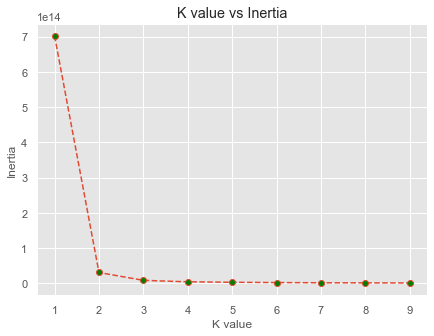

In [125]:
#Using the elbow method to find the optimum number of clusters

X = credit_[credit_.columns[1:]]

inertia_list = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state = RANDOM_STATE)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
    
# Show graph elbow method
plt.figure(figsize=(7,5))
plt.plot(range(1,10),inertia_list,marker='o',markerfacecolor='green',linestyle='dashed')
plt.title('K value vs Inertia')
plt.xlabel('K value')
plt.ylabel('Inertia')

In [126]:
# Declaring Model
model = KMeans(n_clusters=2, random_state = RANDOM_STATE)

# Fitting Model
labels = model.fit_predict(X)
df = pd.DataFrame(labels)

In [127]:
df.value_counts()

0    4706
1     663
dtype: int64

In [129]:
credit_['daily_balance'].describe()

count     5369.000000
mean      7029.858862
std       3906.014140
min        211.176471
25%       3868.316461
50%       6388.536013
75%       9348.393120
max      26297.662332
Name: daily_balance, dtype: float64

In [130]:
# The above model shows customers are divided into 2 clusters
# We will define the target variable based on these 2 clusters (12% in cluster 0 and 88% in cluster 1)

# We can see that 75% of customers have an average daily balance of less than £9,300, 
# so we take the 80% percentile at roughly £11K & use it as the cutoff point to help define the target variable.
# We will define a creditworthy person as someone who has an average daily balance of at least £11000 
# and loan_status other than 1(in default) or 3(in debt)

credit_data = credit_.copy()

credit_data["daily_balance"] = credit_["daily_balance"].map(lambda val: 1 if val < 11000 else 0)
credit_data["loan_status"] = credit_["loan_status"].map(lambda val: 1 if val == (1 or 3) else 0)

credit_data['Creditworthy'] = credit_data["daily_balance"] + credit_data["loan_status"]
# if average_bal + loan_status is equal to 0 then, creditworthy = 1
credit_data['Creditworthy'] = credit_data['Creditworthy'].map(lambda val: 1 if val == 0 else 0)

In [131]:
credit_data['Creditworthy'].value_counts()

0    4515
1     854
Name: Creditworthy, dtype: int64

In [132]:
credit_data.drop(['daily_balance','loan_status'], axis = 1, inplace=True )

# we have to drop the average balance & loan status columns now because they are dependant variables

## Exploratory Data Analysis

In [133]:
credit_data.describe()

,age,district,region,population,no_cities,ratio_urban,avg_sal,unemp_95,unemp_96,no_enterp,...,days_loan_issued,months_loan_left,household payment,insurance payment,leasing,loan payment,card_type,days_ccard_issued,female,Creditworthy
count,5369.000000,5369.000000,5369.000000,5.369000e+03,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,...,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000
mean,45.801639,35.254796,3.505122,2.692806e+05,5.517974,69.240045,9510.758614,2.912486,3.490942,121.191097,...,127.374371,2.269678,3172.464891,155.487614,163.452822,694.782380,2.571987,77.716148,0.492643,0.159061
std,17.282283,21.801799,2.255235,3.590500e+05,2.940686,19.896870,1330.686689,1.889014,2.134924,23.106521,...,363.296790,8.866517,3028.367320,740.985600,663.172252,1820.400626,1.007094,239.195706,0.499992,0.365767
min,12.000000,0.000000,0.000000,4.282100e+04,1.000000,33.900000,8110.000000,0.290000,0.430000,81.000000,...,0.000000,-54.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,17.000000,2.000000,8.888400e+04,4.000000,52.700000,8547.000000,1.600000,1.960000,105.000000,...,0.000000,0.000000,308.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,45.000000,33.000000,4.000000,1.219470e+05,6.000000,63.100000,8980.000000,2.770000,3.470000,116.000000,...,0.000000,0.000000,2556.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,59.000000,53.000000,6.000000,2.261220e+05,8.000000,85.600000,9897.000000,4.010000,4.790000,131.000000,...,0.000000,0.000000,4673.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000
max,88.000000,76.000000,7.000000,1.204953e+06,11.000000,100.000000,12541.000000,7.340000,9.400000,167.000000,...,2005.000000,59.233333,14882.000000,12504.000000,4975.200000,9910.000000,3.000000,1880.000000,1.000000,1.000000


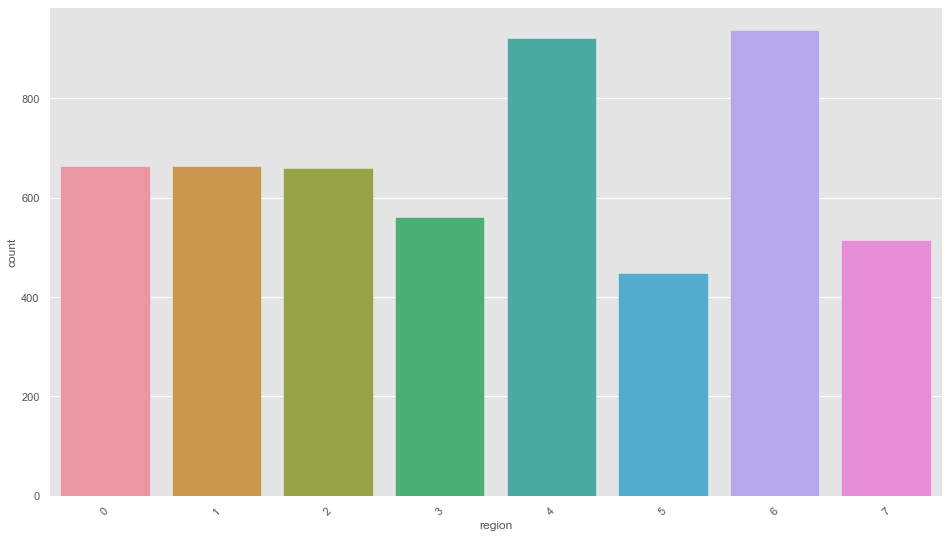

In [134]:
# count plot of region column
sns.countplot(x ='region', data = credit, dodge='True')

plt.xticks(rotation=45)
 
# Show the plot
plt.show()

The distribution is almost even across the regions

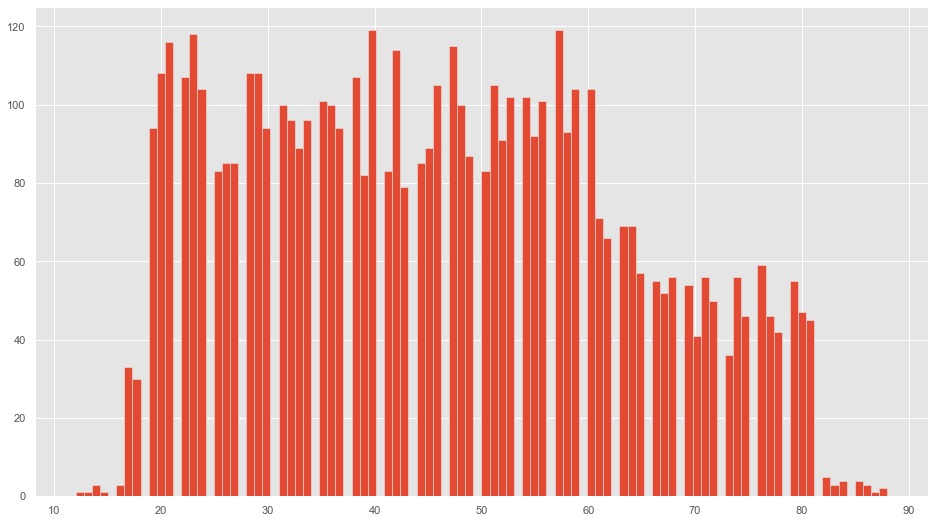

In [135]:
# count plot of age column
plt.hist(credit['age'], bins = 100) 
  
# Display the plot 
plt.show()

Age distribution of clients are normally distributed but is skewed to the left with under 60's forming the majority

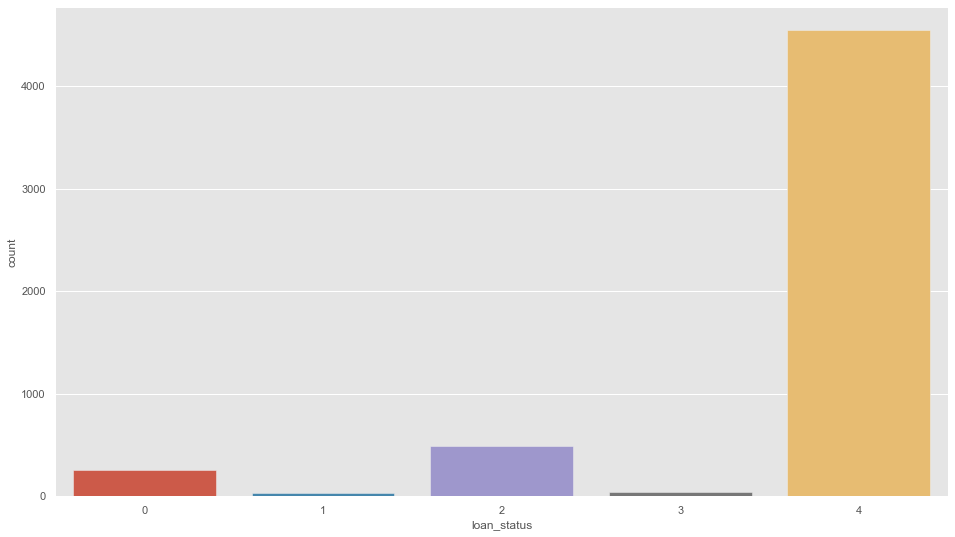

In [136]:
# count plot of loan status column
sns.countplot(x ='loan_status', data = credit, dodge='True')
 
# Show the plot
plt.show()

The above shows majority of customers are not in arrears or in default. So most customers who were given a loan are likely to be good customers.

## Feature Selection & Engineering

### Filter Method: Step 1

In [137]:
feature_cols = credit_data.columns[1:].drop(['Creditworthy'])

feature_cols

Index(['age', 'district', 'region', 'population', 'no_cities', 'ratio_urban',
       'avg_sal', 'unemp_95', 'unemp_96', 'no_enterp', 'no_crimes95',
       'no_crimes96', 'monthly_income', 'monthly_spending', 'loan_term',
       'days_loan_issued', 'months_loan_left', 'household payment',
       'insurance payment', 'leasing', 'loan payment', 'card_type',
       'days_ccard_issued', 'female'],
      dtype='object')

In [138]:
X = credit_data[feature_cols]
y = credit_data['Creditworthy']

In [139]:
importances = X.apply(lambda x: x.corr(y))
indices = np.argsort(importances)
print(importances[indices])

card_type           -0.244000
age                 -0.124882
region              -0.024023
no_cities           -0.010799
female              -0.009898
ratio_urban          0.001633
unemp_95             0.004763
no_crimes96          0.006804
no_crimes95          0.007021
population           0.007188
avg_sal              0.010288
unemp_96             0.010701
no_enterp            0.014874
district             0.031874
household payment    0.080592
insurance payment    0.126570
months_loan_left     0.145240
leasing              0.147680
days_ccard_issued    0.233379
loan_term            0.234760
days_loan_issued     0.253009
monthly_spending     0.260129
loan payment         0.266407
monthly_income       0.637520
dtype: float64


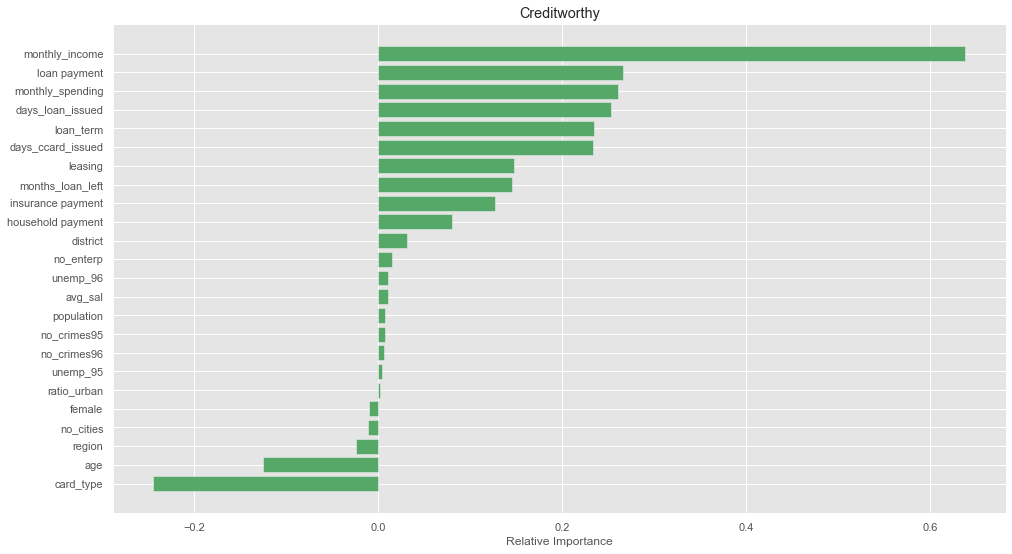

In [140]:
names=feature_cols
plt.title('Creditworthy')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We want to keep features with only a high correlation with the target variable. This implies that the input feature has a high influence in predicting the target variable.
We set the threshold to the absolute value of 0.1. We keep input features only if the correlation of the input feature with the target variable is greater than 0.1

In [141]:
for i in range(0, 21):
    if np.abs(importances[i])>0.1:
        print(names[i])

age
monthly_income
monthly_spending
loan_term
days_loan_issued
months_loan_left
insurance payment
leasing
loan payment


### Filter Method: Step 2

Identify input features that have a low correlation with other independent variables.

In [142]:
names = ['age','monthly_income', 'monthly_spending', 'loan_term', 'days_loan_issued', 'months_loan_left', 
         'insurance payment', 'leasing', 'loan payment']

In [143]:
X = credit_data[names]

In [144]:
for i in range(0,len(X.columns)):
    for j in  range(0,len(X.columns)):
        if i!=j:
            corr_1=np.abs(X[X.columns[i]].corr(X[X.columns[j]]))
            if corr_1 <0.3:
                print( X.columns[i] , " is not correlated  with ", X.columns[j])
            elif corr_1>0.75:
                print( X.columns[i] , " is highly  correlated  with ", X.columns[j])

age  is not correlated  with  monthly_income
age  is not correlated  with  monthly_spending
age  is not correlated  with  loan_term
age  is not correlated  with  days_loan_issued
age  is not correlated  with  months_loan_left
age  is not correlated  with  insurance payment
age  is not correlated  with  leasing
age  is not correlated  with  loan payment
monthly_income  is not correlated  with  age
monthly_income  is not correlated  with  months_loan_left
monthly_income  is not correlated  with  insurance payment
monthly_income  is not correlated  with  leasing
monthly_spending  is not correlated  with  age
monthly_spending  is not correlated  with  loan_term
monthly_spending  is not correlated  with  days_loan_issued
monthly_spending  is not correlated  with  months_loan_left
monthly_spending  is not correlated  with  insurance payment
monthly_spending  is not correlated  with  leasing
monthly_spending  is not correlated  with  loan payment
loan_term  is not correlated  with  age
loan_t

### Filter Method: Step 3
Find the information gain or mutual information of the independent variable with respect to a target variable

In [145]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# names=feature_cols.drop(['leasing','insurance payment','months_loan_left'])
X = credit_data[names]

mi = mutual_info_regression(X, y)

C:\Users\amath\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


<AxesSubplot:>

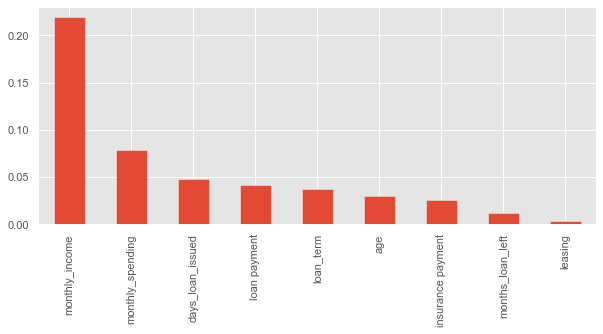

In [146]:
# Plotting the mutual information

mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

## Unsupervised Machine Learning Modelling

### K-Means Clustering

In [151]:
# Declaring Model
model = KMeans(n_clusters=2, random_state = RANDOM_STATE)

# Fitting Model
labels = model.fit_predict(X)

# Create a DataFrame with labels and targets as columns: df
df = pd.DataFrame({'labels':labels, 'targets': y})

# Create crosstab: ct
ct = pd.crosstab(df["labels"],df["targets"])

# Display ct
print(ct)

targets     0    1
labels            
0        3570  124
1         945  730


730 out of 854 customers were predicted correctly to be credit worthy. Hence, it's a good model to identify the most suitable customers to be offered a credit card product

In [152]:
# Prediction on the entire data
all_predictions = model.predict(X)